<a href="https://colab.research.google.com/github/Jumabek/net_intrusion_detection/blob/transformer/Comparing_nhead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id 1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
!unzip MachineLearningCSV.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-t3RdDpmqMs4ABt9oobSapeNYTZJ9tpu
To: /content/MachineLearningCSV.zip
100% 235M/235M [00:01<00:00, 194MB/s]
Archive:  MachineLearningCSV.zip
replace MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  
replace MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
replace MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
replace MachineLearningCVE/Thur

In [2]:
!wget https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py

--2023-08-18 02:40:17--  https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3790 (3.7K) [text/plain]
Saving to: ‘preprocessing.py’

preprocessing.py    100%[===================>]   3.70K  --.-KB/s    in 0s      

2023-08-18 02:40:18 (35.7 MB/s) - ‘preprocessing.py’ saved [3790/3790]



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from preprocessing import load_data, balance_data, normalize
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [4]:
dataroot = 'MachineLearningCVE/'
from preprocessing import read_data
data = read_data(dataroot,'*.pcap_ISCX.csv')

[########################################] | 100% Completed | 29.51 s


In [5]:
# Load, balance and normalize the data
X, y = load_data(dataroot)
X, y = balance_data(X, y, seed=42)
X = normalize(X)

[########################################] | 100% Completed | 29.01 s
there are 2830743 flow records with 79 feature dimension
stripped column names
dropped bad columns
There are 0 nan entries
converted to numeric


In [6]:
# Use only 10% of the data
sample_idx = np.random.choice(len(X), int(0.1*len(X)), replace=False)
X = X[sample_idx]
y = y[sample_idx]

In [7]:
# Splitting the Data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [8]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=64, nhead=8, num_layers=4, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a fake batch dimension for the transformer
        x = self.transformer(x, x)  # Encoder-Decoder Self-Attention
        x = x.squeeze(1)
        x = self.fc(x)
        return x


def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.cuda()
            labels = labels.cuda()

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    return accuracy, f1, precision, recall


In [9]:
def train_model(nhead):
    # Dataset and Dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    batch_size = 5120
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model Configuration
    input_dim = X_train_tensor.shape[1]
    num_classes = len(np.unique(y))
    model = TransformerModel(input_dim, num_classes, nhead = nhead, d_model=nhead*nhead)
    model = model.cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for i, (data, labels) in enumerate(train_loader):
            data = data.cuda()
            labels = labels.cuda()

            outputs = model(data)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Num heads: {nhead}, Epoch [{epoch + 1}/5], Loss: {running_loss / len(train_loader)}')
    accuracy, f1, precision, recall = evaluate_model(model, DataLoader(test_dataset, batch_size=batch_size))
    print(f'Num heads: {nhead}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    return accuracy, f1, precision, recall



In [10]:
# Lists to store metrics for each model configuration
nheads = [2,3,4,5,6,7,8,9,10]
accuracies = []
f1_scores = []
precisions = []
recalls = []

for nhead in nheads:
    acc, f1, prec, rec = train_model(nhead)
    accuracies.append(acc)
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)


Num heads: 2, Epoch [1/5], Loss: 2.585339203858987
Num heads: 2, Epoch [2/5], Loss: 2.3466214583470273
Num heads: 2, Epoch [3/5], Loss: 2.1861253457191663
Num heads: 2, Epoch [4/5], Loss: 2.073125674174382
Num heads: 2, Epoch [5/5], Loss: 1.9799619271205022
Num heads: 2, Epoch [6/5], Loss: 1.8778635416275415
Num heads: 2, Epoch [7/5], Loss: 1.7717046309740117
Num heads: 2, Epoch [8/5], Loss: 1.682565423158499
Num heads: 2, Epoch [9/5], Loss: 1.604793062576881
Num heads: 2, Epoch [10/5], Loss: 1.530127152418479
Num heads: 2, Accuracy: 0.6314, F1: 0.6081, Precision: 0.6901, Recall: 0.6314
Num heads: 3, Epoch [1/5], Loss: 2.414217294790806
Num heads: 3, Epoch [2/5], Loss: 1.8678340514500935
Num heads: 3, Epoch [3/5], Loss: 1.5346826895689354
Num heads: 3, Epoch [4/5], Loss: 1.2796357289338722
Num heads: 3, Epoch [5/5], Loss: 1.0717540841836195
Num heads: 3, Epoch [6/5], Loss: 0.9115618222799057
Num heads: 3, Epoch [7/5], Loss: 0.7766994956212167
Num heads: 3, Epoch [8/5], Loss: 0.66387985

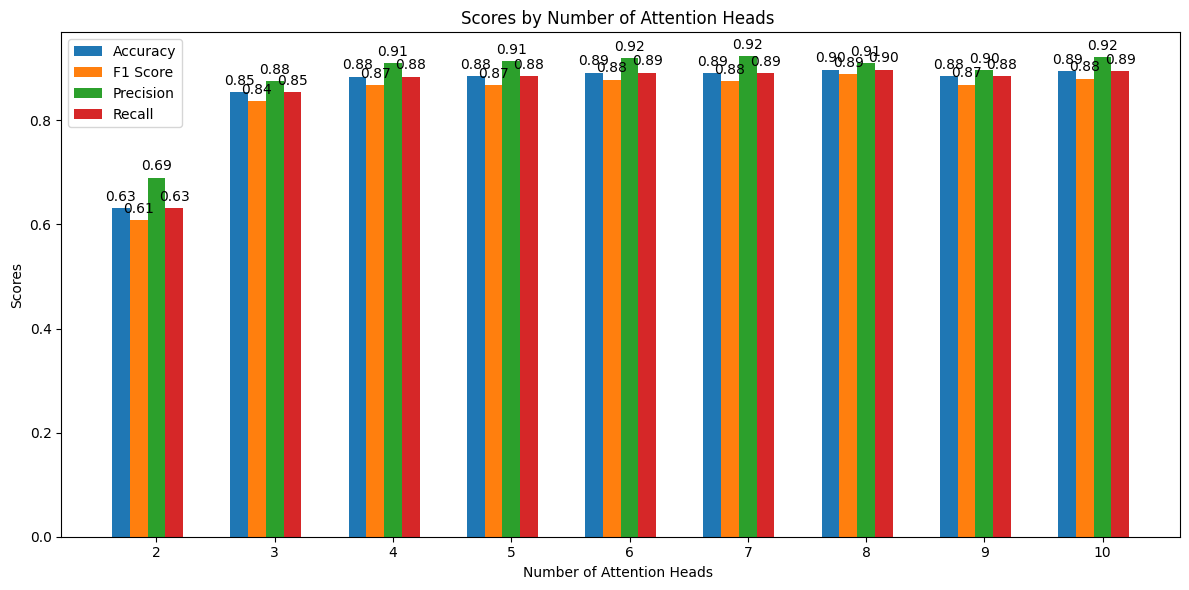

In [11]:
# Plotting the metrics
import matplotlib.pyplot as plt
import numpy as np

# Create an index for each tick position
x_indexes = np.arange(len(nheads))
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Generate bar graphs
rects1 = ax.bar(x_indexes - 2 * width, accuracies, width, label='Accuracy')
rects2 = ax.bar(x_indexes - width, f1_scores, width, label='F1 Score')
rects3 = ax.bar(x_indexes, precisions, width, label='Precision')
rects4 = ax.bar(x_indexes + width, recalls, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of Attention Heads ')
ax.set_ylabel('Scores')
ax.set_title('Scores by Number of Attention Heads ')
ax.set_xticks(x_indexes)
ax.set_xticklabels(nheads)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height
for rects in [rects1, rects2, rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig.tight_layout()

plt.show()


In [12]:
print("nheads:", nheads)
print("accuracies:", accuracies)
print("f1_scores:", f1_scores)
print("precisions:", precisions)
print("recalls:", recalls)

nheads: [2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies: [0.6314116150911403, 0.8548584616833875, 0.8842965475012953, 0.8847675568743818, 0.8918091470020253, 0.8911261834110499, 0.8977438651029156, 0.8845320521878386, 0.8949884602703594]
f1_scores: [0.6080794607624213, 0.8363995984994207, 0.8680905472510936, 0.8683736116929807, 0.8784893068640683, 0.8750786446273434, 0.8887876649462082, 0.8687744026848431, 0.8802601569558449]
precisions: [0.6900742608660202, 0.8755710778427694, 0.9095735123128229, 0.9137875792955837, 0.9202073548311643, 0.9230256764784139, 0.9105737179357994, 0.8973731266185565, 0.9219993843017428]
recalls: [0.6314116150911403, 0.8548584616833875, 0.8842965475012953, 0.8847675568743818, 0.8918091470020253, 0.8911261834110499, 0.8977438651029156, 0.8845320521878386, 0.8949884602703594]
